<a href="https://colab.research.google.com/github/natandreli/ai_project/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Functions used

In [2]:
# Function for performing the correlation matrix
def get_corr_matrix(group, dataset):
    corr_matrix = dataset[group].corr()
    plt.figure(figsize = (10, 10))
    ax = sns.heatmap(corr_matrix, cmap = 'RdBu_r', center = 0.0)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 8, rotation = 0)
    plt.show()
    return corr_matrix

## LOAD DATA

In [4]:
# Train datasets
train_t = pd.read_csv('train_transaction.csv', index_col='TransactionID')
train_i = pd.read_csv('train_identity.csv', index_col='TransactionID')
train = pd.merge(train_t, train_i, on = 'TransactionID', how = 'left')

# Test datasets
test_t = pd.read_csv('test_transaction.csv', index_col='TransactionID')
test_i = pd.read_csv('test_identity.csv', index_col='TransactionID')
fix = {o:n for o, n in zip(test_i.columns, train_i.columns)}
test_i.rename(columns = fix, inplace=True)
test = pd.merge(test_t, test_i, on = 'TransactionID', how = 'left')

# Target
train_y = train['isFraud'].copy()

# Shape
print(f'Train shape: {train.shape}\nTest shape: {test.shape}')

Train shape: (590540, 433)
Test shape: (506691, 432)


## DATA EXPLORATION

### Discover data types

In [5]:
columns = train.columns

for column in columns:
  print('%20s'%column, train[column].dtype)

             isFraud int64
       TransactionDT int64
      TransactionAmt float64
           ProductCD object
               card1 int64
               card2 float64
               card3 float64
               card4 object
               card5 float64
               card6 object
               addr1 float64
               addr2 float64
               dist1 float64
               dist2 float64
       P_emaildomain object
       R_emaildomain object
                  C1 float64
                  C2 float64
                  C3 float64
                  C4 float64
                  C5 float64
                  C6 float64
                  C7 float64
                  C8 float64
                  C9 float64
                 C10 float64
                 C11 float64
                 C12 float64
                 C13 float64
                 C14 float64
                  D1 float64
                  D2 float64
                  D3 float64
                  D4 float64
                  D5 floa

### Missing values in columns

In [6]:
# Sum of empty data per column in train dataset
nan = train.isna().sum()
nan[nan!=0]

card2           8933
card3           1565
card4           1577
card5           4259
card6           1571
               ...  
id_36         449555
id_37         449555
id_38         449555
DeviceType    449730
DeviceInfo    471874
Length: 414, dtype: int64

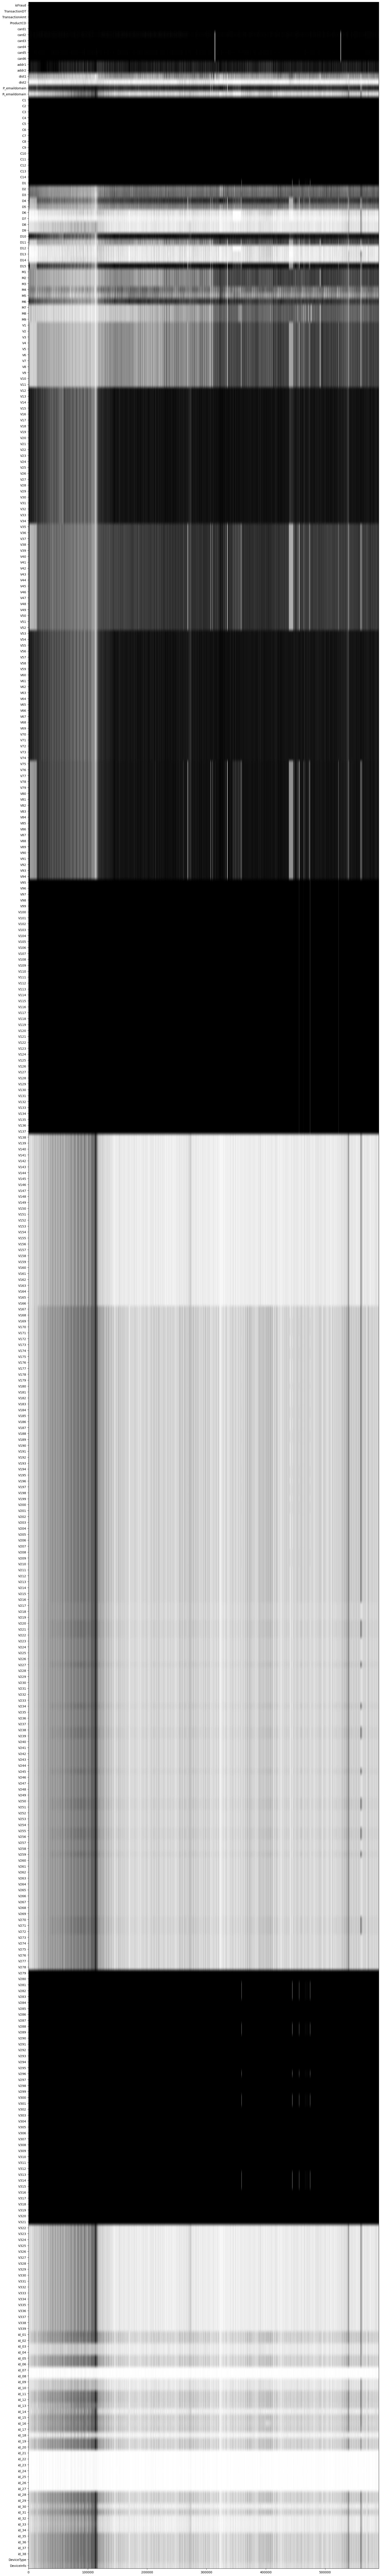

In [7]:
fig, ax = plt.subplots(figsize=(300, 150))
ax.imshow(train.isna().values.T, cmap='gray')
ax.set_aspect(10000)
plt.yticks(range(train.shape[1]), train.columns)
plt.show()

#### Proportion of missing data in each column

In [8]:
num_rows = train.shape[0]
nan = train.isna().sum() / num_rows
print(f'Porcentaje mínimo de datos faltantes: {nan.min()*100} %\nPorcentaje máximo de datos faltantes: {nan.max()*100} %\n')
nan[nan != 0]

Porcentaje mínimo de datos faltantes: 0.0 %
Porcentaje máximo de datos faltantes: 99.19615944728554 %



card2         0.015127
card3         0.002650
card4         0.002670
card5         0.007212
card6         0.002660
                ...   
id_36         0.761261
id_37         0.761261
id_38         0.761261
DeviceType    0.761557
DeviceInfo    0.799055
Length: 414, dtype: float64

#### Proportion of missing data in the V columns

In [9]:
num_rows = train.shape[0]
nan = train.loc[:, 'V1':'V339'].isna().sum() / num_rows
print(f'Porcentaje mínimo de datos faltantes: {nan.min()*100} %\nPorcentaje máximo de datos faltantes: {nan.max()*100} %\n')
nan[nan != 0]

Porcentaje mínimo de datos faltantes: 0.0020320384732617604 %
Porcentaje máximo de datos faltantes: 86.12371727571374 %



V1      0.472935
V2      0.472935
V3      0.472935
V4      0.472935
V5      0.472935
          ...   
V335    0.860550
V336    0.860550
V337    0.860550
V338    0.860550
V339    0.860550
Length: 339, dtype: float64

### Inspect numeric columns

In [10]:
train._get_numeric_data().describe().T

,count,mean,std,min,25%,50%,75%,max
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.0,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.0,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.0,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.0,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,214.000,361.000,512.0,6.000000e+02
...,...,...,...,...,...,...,...,...
id_22,5169.0,1.600271e+01,6.897665e+00,10.000,14.000,14.000,14.0,4.400000e+01
id_24,4747.0,1.280093e+01,2.372447e+00,11.000,11.000,11.000,15.0,2.600000e+01
id_25,5132.0,3.296089e+02,9.746109e+01,100.000,321.000,321.000,371.0,5.480000e+02
id_26,5163.0,1.490703e+02,3.210199e+01,100.000,119.000,149.000,169.0,2.160000e+02


#### Correlation of the C numeric columns

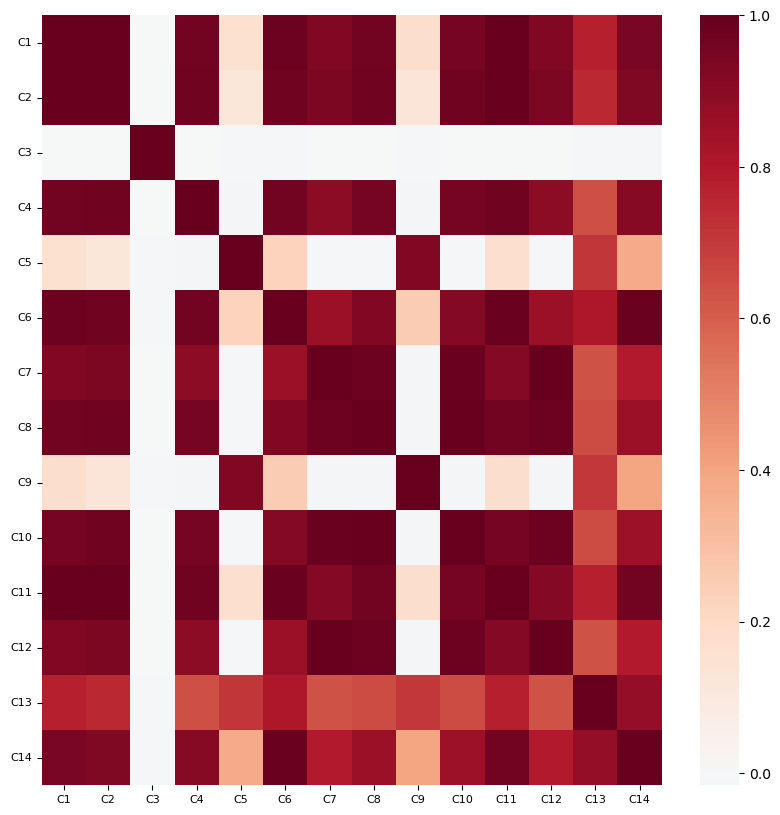

In [11]:
corr_matrix = get_corr_matrix(train.loc[:, 'C1':'C14'].columns, train)

#### Correlation of the D numeric columns

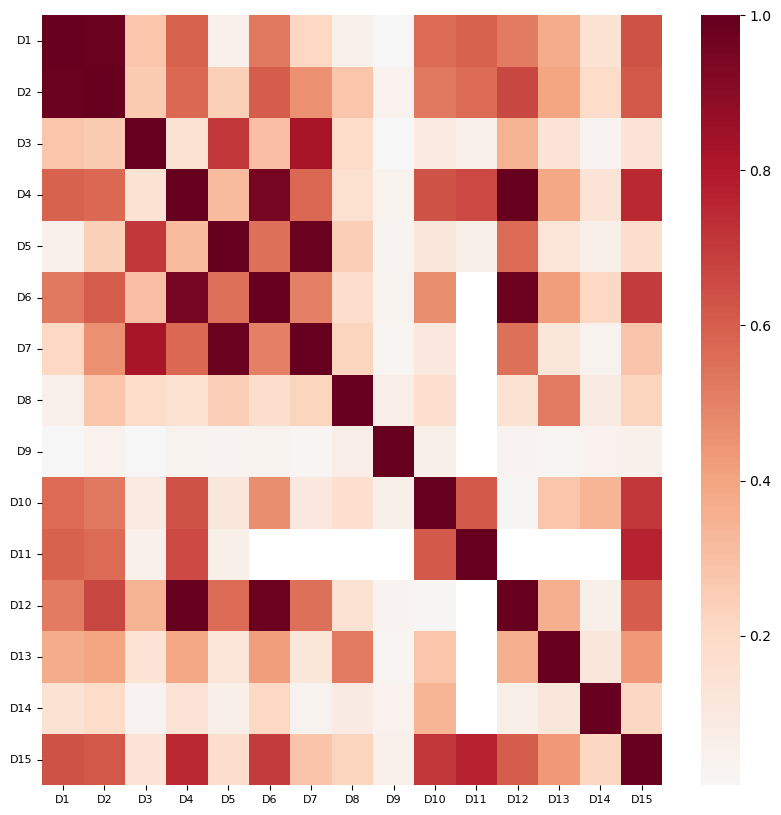

In [12]:
corr_matrix = get_corr_matrix(train.loc[:, 'D1':'D15'].columns, train)

#### Correlation of the V columns

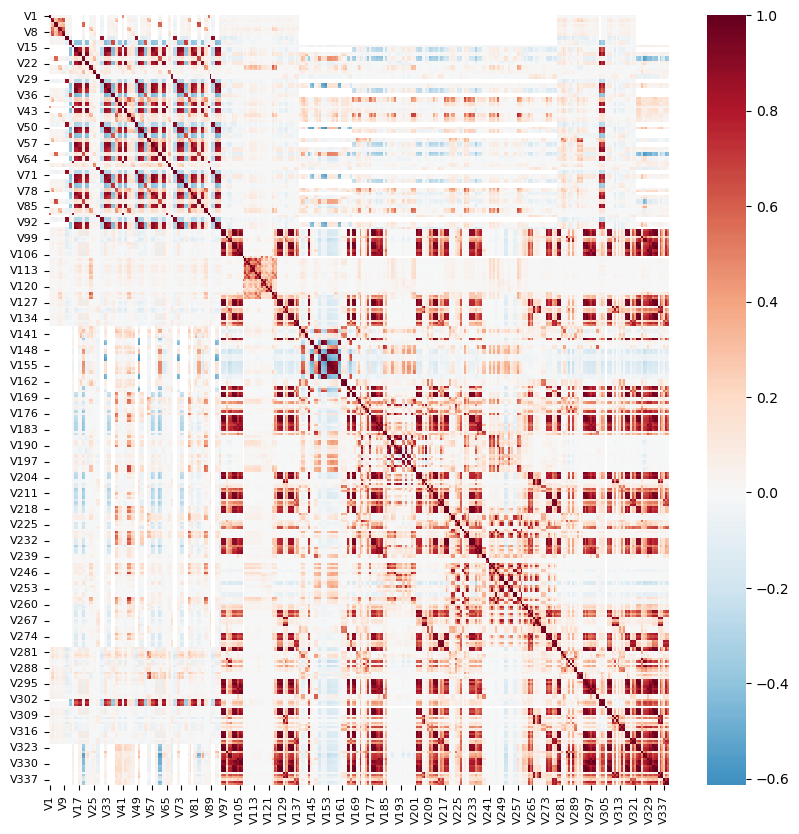

In [13]:
corr_matrix = get_corr_matrix(train.loc[:, 'V1':'V339'].columns, train)